In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

SCRIPT_DIRNAME = './'

LABELS = dict()
for line in np.loadtxt(os.path.join(SCRIPT_DIRNAME, 'synset_words.txt'), \
                        str, delimiter="\t"):
    LABELS.update({line[0]:line[1]})

FILENAME = ['caffenet.batch001_top5.csv',
            'hogcaffenet.batch001_top5.csv',
            'squeezenet.batch001_top5.csv',
            'hogsqueezenet.batch001_top5.csv',
            'googlenet.batch001_top5.csv',
            'hoggooglenet.batch001_top5.csv'
            ]

def retrieve_avgp():
    CHECK_ITEMS = 10
    TOP_K = 5
    LOADFORMAT = 'object,object'
    for i in range(TOP_K):
        LOADFORMAT = LOADFORMAT + ',object,float'

    vecavgp = []
    for fname in FILENAME:
        RES = np.loadtxt(os.path.join(SCRIPT_DIRNAME, fname), \
                        dtype=LOADFORMAT, delimiter=',', skiprows=1)

        GROUND_TRUTH = RES['f1']
        PRED_ID = RES['f2']
        PRED_SCORE = RES['f3']

        CLASS_ID = np.unique(GROUND_TRUTH)
        ap = np.zeros_like(CLASS_ID).astype(float)
        ap_pos = np.zeros_like(CLASS_ID).astype(int)
        relcnt = np.zeros_like(CLASS_ID).astype(int)
        relevant = np.equal(GROUND_TRUTH, PRED_ID)
        precision = np.zeros_like(relevant).astype(float)

        progress = int(len(CLASS_ID)*0.2)
        print('Computing average precision of %s' % (fname))
        for idx, classid in np.ndenumerate(CLASS_ID):
            if idx[0] % progress == 0:
                print('in processing class %d ...' % idx[0])
            pos = np.where(GROUND_TRUTH == classid)[0]
            ap_pos[idx] = pos[-1]
            relcnt[idx] = np.count_nonzero(relevant[pos])

            cnt = 0
            for i, rel_pos in np.ndenumerate(pos):
                if relevant[rel_pos] == True:
                    cnt = cnt + 1
                    precision[rel_pos] = float(cnt)/(float(i[0])+1.)
                else:
                    precision[rel_pos] = 0

            ap[idx] = np.sum(precision[pos])/float(relcnt[idx])

        vecavgp.append(ap)
        summary = zip(CLASS_ID, ap)
        summary = sorted(summary, key=lambda x: x[1], reverse=True)

        print("\nhighest %d ranks" % (CHECK_ITEMS))
        for classid, avgprec in summary[0:CHECK_ITEMS]:
            print(classid, "%.3f"%(avgprec*100), LABELS[classid])
        print("\nlowest %d ranks" % (CHECK_ITEMS))
        for classid, avgprec in summary[-CHECK_ITEMS:]:
            print(classid, "%.3f"%(avgprec*100), LABELS[classid])
        print("=======")

    return CLASS_ID, vecavgp

In [4]:
CLASS_ID, VECAVGP = retrieve_avgp()

Computing average precision of caffenet.batch001_top5.csv
in processing class 0 ...
in processing class 200 ...
in processing class 400 ...
in processing class 600 ...
in processing class 800 ...

highest 10 ranks
n12057211 99.648 yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum
n03841143 99.599 odometer, hodometer, mileometer, milometer
n02489166 98.760 proboscis monkey, Nasalis larvatus
n01820546 98.160 lorikeet
n03777568 97.391 Model T
n03393912 96.688 freight car
n01872401 95.974 echidna, spiny anteater, anteater
n01828970 95.886 bee eater
n13037406 95.312 gyromitra
n04019541 95.132 puck, hockey puck

lowest 10 ranks
n03041632 13.314 cleaver, meat cleaver, chopper
n04152593 13.080 screen, CRT screen
n02999410 12.517 chain
n04376876 12.121 syringe
n03995372 11.481 power drill
n03658185 11.176 letter opener, paper knife, paperknife
n04357314 10.348 sunscreen, sunblock, sun blocker
n04525038 8.675 velvet
n04154565 8.387 screwdriver
n04270147 5

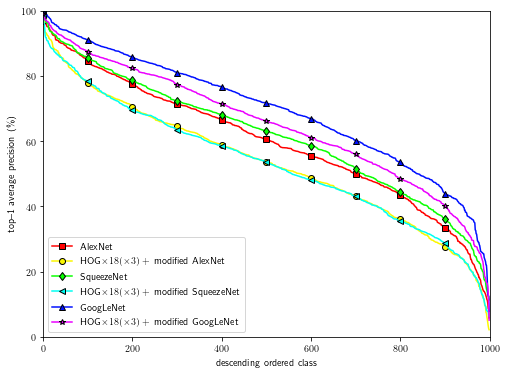

In [18]:
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.figsize'] = [8, 6]
LEGENDS = ['AlexNet',
           r'HOG\(\times18(\times3)\) + modified AlexNet',
           'SqueezeNet',
           r'HOG\(\times18(\times3)\) + modified SqueezeNet',
           'GoogLeNet',
           r'HOG\(\times18(\times3)\) + modified GoogLeNet']

MARKER_ITVL = 100
MARKERS = ['s', 'o', 'd', '<', '^', '*']
COLORS = plt.cm.get_cmap('hsv', len(FILENAME)+1)
for i in range(len(FILENAME)):
    plt.plot(range(len(CLASS_ID)), \
                [prec*100 for prec in sorted(VECAVGP[i], reverse=True)], \
                MARKERS[i], \
                color=COLORS(i), ls='-', \
                markevery=MARKER_ITVL, \
                markeredgecolor='k', \
                label=LEGENDS[i])
plt.legend(loc='lower left')
plt.xlabel('descending ordered class')
plt.ylabel('top--1 average precision (\%)')
plt.ylim(0, 100)
plt.xlim(0, len(CLASS_ID))
plt.show()

In [26]:
# Cosine distance for the complement in positive space, that is:
# D_{C}(A,B)=1-S_{C}(A,B) where D_C is the cosine distance 
# and S_{C} is the cosine similarity.
print("Cosine Distance")
print(" CaffeNet: %.3f" % (1 - np.dot(VECAVGP[0],VECAVGP[1])/(np.linalg.norm(VECAVGP[0])*np.linalg.norm(VECAVGP[1]))))
print(" SqueezeNet: %.3f" % (1 - np.dot(VECAVGP[2],VECAVGP[3])/(np.linalg.norm(VECAVGP[2])*np.linalg.norm(VECAVGP[3]))))
print(" GoogLeNet: %.3f" % (1 - np.dot(VECAVGP[4],VECAVGP[5])/(np.linalg.norm(VECAVGP[4])*np.linalg.norm(VECAVGP[5]))))

Cosine Distance
 CaffeNet: 0.012
 SqueezeNet: 0.013
 GoogLeNet: 0.007


In [30]:
AVGPREC_LIMIT = 0.4
print("\naverage precision limit: %.1f" % AVGPREC_LIMIT)
CLASS_COUNTS = np.zeros_like(VECAVGP[0]).astype(int)
for i in range(len(FILENAME)):
    CLASS_MASK = np.array([1 if ap < AVGPREC_LIMIT else 0 for ap in VECAVGP[i]])
    print('-', FILENAME[i], '%d classes' % (len(np.where(CLASS_MASK > 0)[0])))
    CLASS_COUNTS = np.add(CLASS_COUNTS, CLASS_MASK)
    
print ('\n* total %d unique classes' % (np.count_nonzero(CLASS_COUNTS)))
for i in range(len(FILENAME)):
    print ('  %d model(s) are found in %d classes' % (i+1, len(np.where(CLASS_COUNTS == (i+1))[0])))


average precision limit: 0.4
- caffenet.batch001_top5.csv 166 classes
- hogcaffenet.batch001_top5.csv 250 classes
- squeezenet.batch001_top5.csv 138 classes
- hogsqueezenet.batch001_top5.csv 251 classes
- googlenet.batch001_top5.csv 59 classes
- hoggooglenet.batch001_top5.csv 98 classes

* total 329 unique classes
  1 model(s) are found in 98 classes
  2 model(s) are found in 69 classes
  3 model(s) are found in 40 classes
  4 model(s) are found in 45 classes
  5 model(s) are found in 36 classes
  6 model(s) are found in 41 classes


In [31]:
print ('* details:')
LOG_LIMIT = [1, 3]
example = 0
counter_example = 0
for idx in np.where(CLASS_COUNTS > 0)[0]:
    print(' ', CLASS_ID[idx], CLASS_COUNTS[idx], end="")
    if CLASS_COUNTS[idx] >= LOG_LIMIT[0] and CLASS_COUNTS[idx] <= LOG_LIMIT[1]:
        flag = False
        if (VECAVGP[0][idx] >= VECAVGP[1][idx] and VECAVGP[2][idx] >= VECAVGP[3][idx]):
            example = example + 1
            print('+', end="")
            flag = True
        if (VECAVGP[0][idx] <= VECAVGP[1][idx] and VECAVGP[2][idx] <= VECAVGP[3][idx]):
            counter_example = counter_example + 1
            print('-', end="")
            flag = True

        if flag == True:
            print(LABELS[CLASS_ID[idx]],)
            for i in range(len(FILENAME)):
                print(' %.3f,' % (VECAVGP[i][idx]), end="")
    print('')
print('* Examples: %d, Counter examples: %d' % (example, counter_example))

* details:
  n01630670 1+common newt, Triturus vulgaris
 0.550, 0.363, 0.701, 0.524, 0.634, 0.535,
  n01644900 2+tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui
 0.411, 0.358, 0.414, 0.371, 0.434, 0.445,
  n01664065 1+loggerhead, loggerhead turtle, Caretta caretta
 0.531, 0.519, 0.609, 0.351, 0.707, 0.700,
  n01667114 1+mud turtle
 0.511, 0.435, 0.472, 0.323, 0.581, 0.494,
  n01667778 3
  n01675722 2+banded gecko
 0.479, 0.337, 0.506, 0.428, 0.679, 0.376,
  n01682714 1
  n01692333 1+Gila monster, Heloderma suspectum
 0.503, 0.502, 0.491, 0.361, 0.669, 0.591,
  n01693334 6
  n01694178 1+African chameleon, Chamaeleo chamaeleon
 0.474, 0.364, 0.496, 0.488, 0.680, 0.572,
  n01698640 1+American alligator, Alligator mississipiensis
 0.510, 0.412, 0.564, 0.276, 0.711, 0.625,
  n01729322 5
  n01729977 2+green snake, grass snake
 0.434, 0.312, 0.476, 0.344, 0.409, 0.454,
  n01737021 2+water snake
 0.427, 0.249, 0.449, 0.290, 0.504, 0.414,
  n01739381 1
  n01740131 6
  n01744401 

  n03770679 1
  n03773504 4
  n03777754 1+modem
 0.463, 0.306, 0.570, 0.451, 0.750, 0.594,
  n03781244 1
  n03782006 5
  n03785016 1+moped
 0.582, 0.446, 0.606, 0.397, 0.579, 0.648,
  n03787032 4
  n03793489 6
  n03794056 1+mousetrap
 0.480, 0.425, 0.664, 0.348, 0.718, 0.635,
  n03796401 4
  n03803284 5
  n03804744 1
  n03814639 4
  n03832673 6
  n03838899 4
  n03843555 5
  n03866082 5
  n03868242 1+oxcart
 0.591, 0.510, 0.696, 0.389, 0.743, 0.686,
  n03868863 5
  n03871628 5
  n03873416 1+paddle, boat paddle
 0.565, 0.559, 0.550, 0.365, 0.548, 0.606,
  n03874599 1+padlock
 0.446, 0.405, 0.405, 0.380, 0.578, 0.587,
  n03876231 4
  n03887697 3+paper towel
 0.423, 0.344, 0.443, 0.186, 0.495, 0.361,
  n03891251 1+park bench
 0.479, 0.475, 0.406, 0.398, 0.583, 0.648,
  n03895866 1
  n03899768 4
  n03903868 2+pedestal, plinth, footstall
 0.475, 0.370, 0.461, 0.301, 0.477, 0.477,
  n03908714 3+pencil sharpener
 0.287, 0.249, 0.488, 0.265, 0.537, 0.421,
  n03916031 3+perfume, essence
 0.434, 